In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from util import RuleClassifier, get_complexity, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate, group_metrics
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances, print_rules
from clustering import make_clustering, eval_clusterings, plot_2d_with_boundaries, compare_indiv_dep_plots,\
                       plot_joint_feature_dependence
shap.initjs()
%matplotlib inline

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, y, feature_names, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
def load(focus_class):
    with open(f'explanations/clustering.diffclf.{focus_class}.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, diffclf_shap_values, focus_class,
                           feature_precisions=feature_precisions, state=state)
    return node

In [5]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

# Generate Explanations

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/indiv.log_odds.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('explanations/diffclf.log_odds.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4.55 s, sys: 79.4 ms, total: 4.63 s
Wall time: 4.9 s


In [7]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    node = make_clustering(comparer, diffclf_shap_values, class_name,
                           feature_precisions=feature_precisions)
    with open(f'clustering.diffclf.{node.focus_class}.pickle', 'wb') as f:
        pickle.dump(node.state, f)

(0, 0)
(0, 1)
(1, 0)
(1, 1)
CPU times: user 6min 9s, sys: 3.74 s, total: 6min 12s
Wall time: 6min 44s


# Traditional SHAP Explanations

In [7]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [8]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.1', 'B.1']]

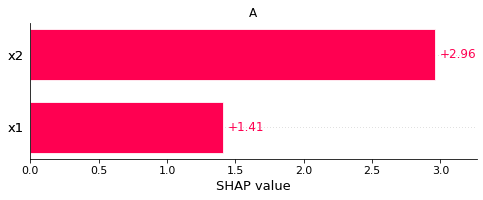

In [9]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.1'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

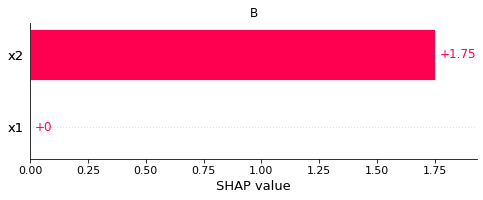

In [10]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.1'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [11]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 687 ms, sys: 18.3 ms, total: 705 ms
Wall time: 881 ms


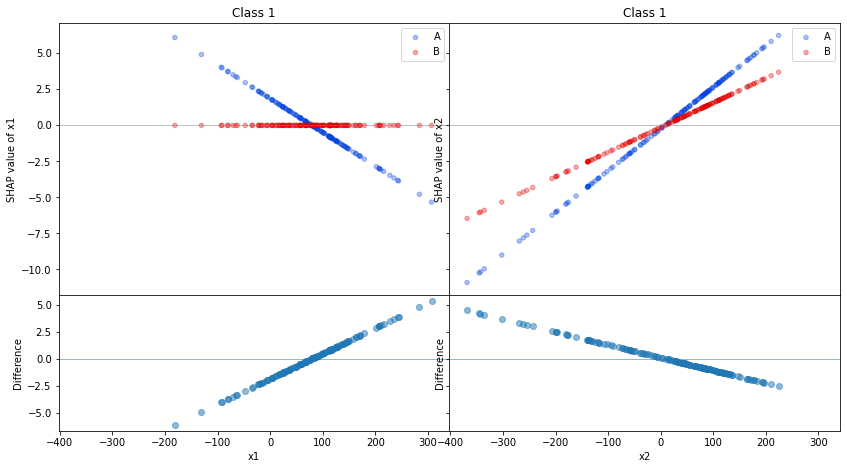

In [15]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex='all', sharey='row', squeeze=False,
                        figsize=(2 * 7, 1.5 * 5), gridspec_kw={'height_ratios': [2,1]})
compare_indiv_dep_plots(node, 'x1', fig=fig, axs=axs.T[0:1].T)
compare_indiv_dep_plots(node, 'x2', fig=fig, axs=axs.T[1:2].T)
plt.savefig('figures/bign-indiv-depplots.pdf')

# Difference Classifier SHAP Explanations

In [14]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

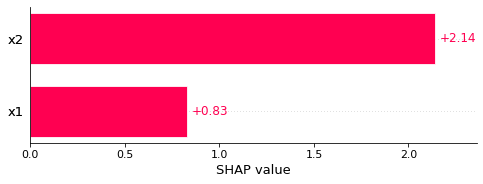

In [15]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

## $(0,1)$

In [16]:
node = load('(0, 1)')
node.distance, node.class_counts

(832.7059637114021,
 (1, 1)    78
 (0, 0)    57
 (0, 1)     9
 (1, 0)     6
 dtype: int64)

### Main Node (L)

In [28]:
node = node.root.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(L,
 (1, 1)    78
 (0, 0)    23
 (0, 1)     9
 (1, 0)     6
 dtype: int64,
 220.50071735972557)

117.36607682827199 <= x1
[Lower CF: x1 == 90.8 --> {'(1, 1)': 9}]


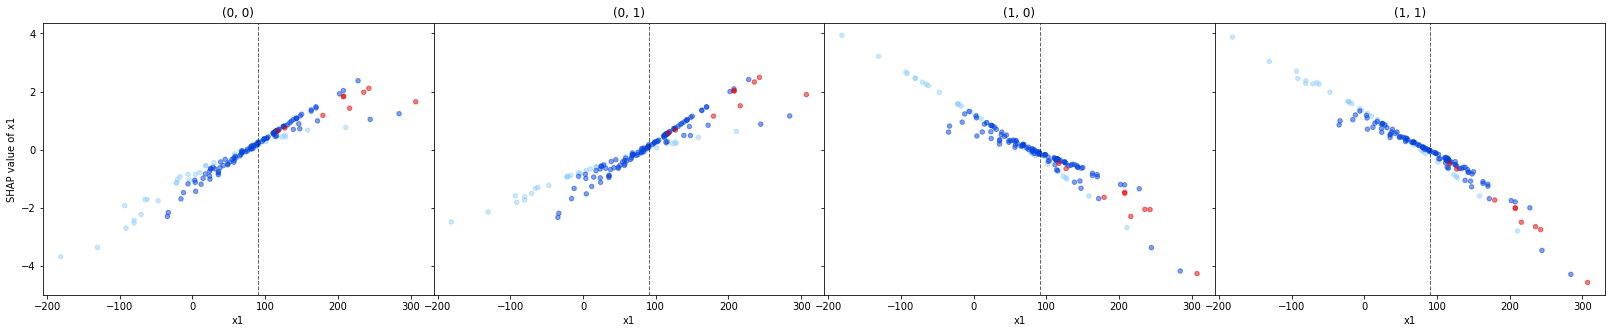

27.9033330838305 <= x2 <= 118.270963914734
[Lower CF: x2 == 22.1 --> {'(0, 0)': 9},
 Upper CF: x2 == 202.8 --> {'(1, 1)': 9}]


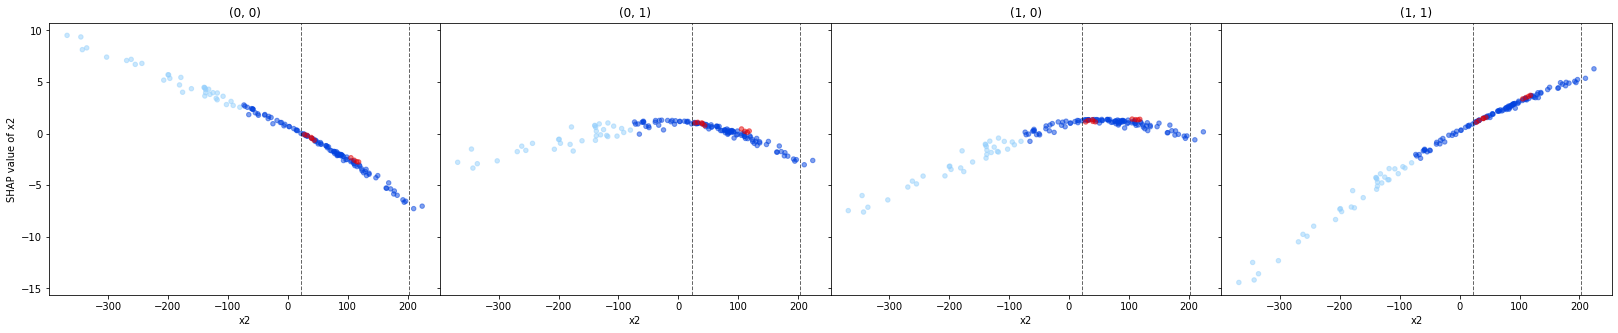

In [19]:
node.root.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

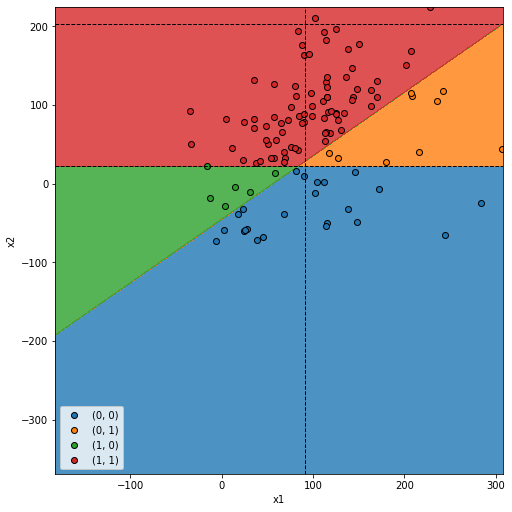

In [29]:
plot_2d_with_boundaries(node)

### Node 1 (LLRRR)

In [30]:
ref_node = node
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LLRRR,
 (0, 1)    4
 dtype: int64,
 1.2314419744421317)

117.36607682827199 <= x1
[Lower CF: x1 == 90.8 --> {'(1, 1)': 9}]


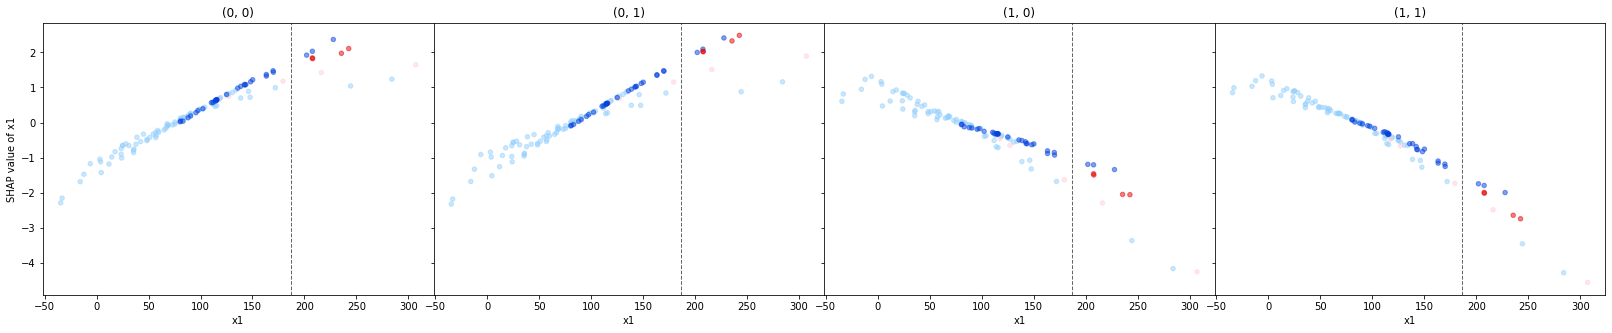

27.9033330838305 <= x2 <= 118.270963914734
[Lower CF: x2 == 22.1 --> {'(0, 0)': 9},
 Upper CF: x2 == 202.8 --> {'(1, 1)': 9}]


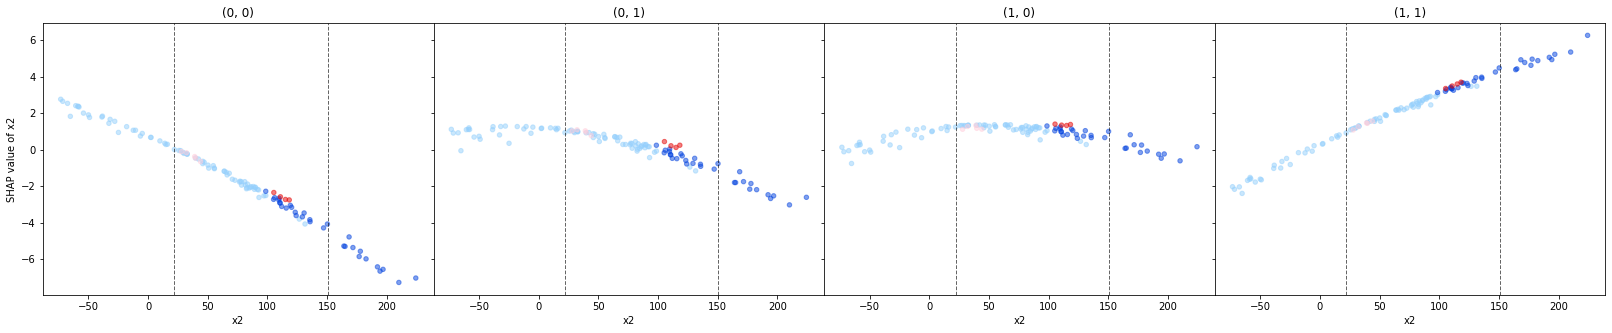

In [27]:
ref_node.plot_feature_dependence(*feature_names, focus=node.get_parent(3), print_stats=True)

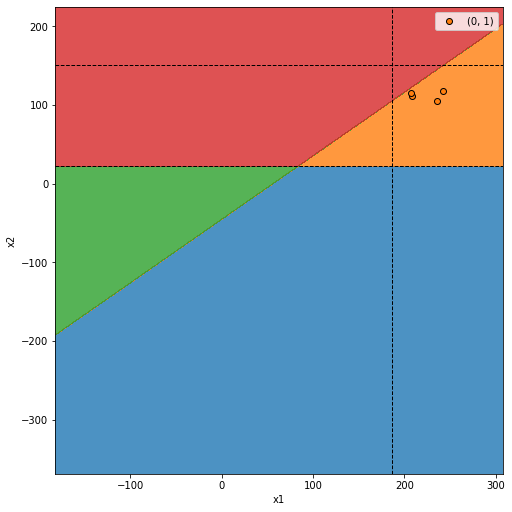

In [31]:
plot_2d_with_boundaries(node)

### Node 2 (LR)

In [32]:
node = ref_node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LR,
 (1, 1)    47
 (0, 0)    23
 (1, 0)     6
 (0, 1)     5
 dtype: int64,
 107.31162216756495)

117.36607682827199 <= x1
[Lower CF: x1 == 90.8 --> {'(1, 1)': 9}]


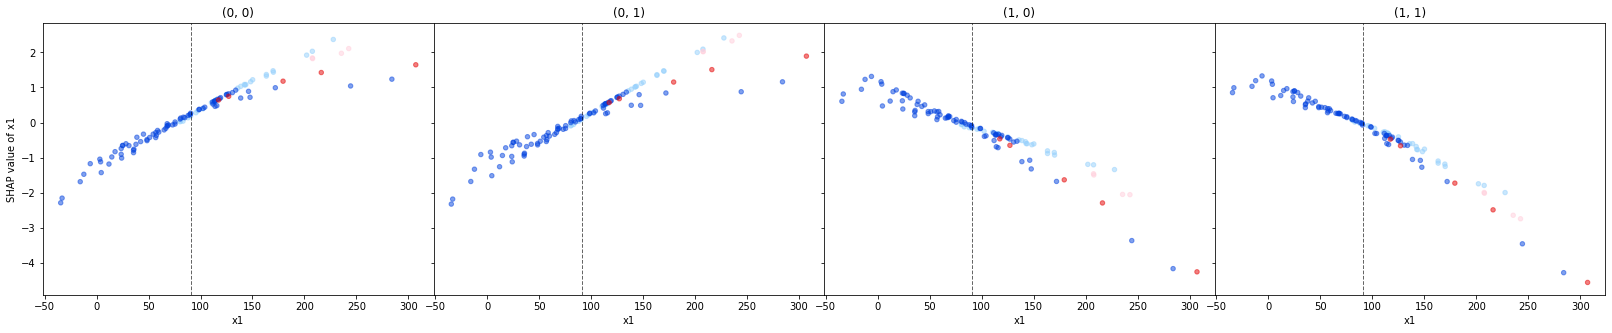

27.9033330838305 <= x2 <= 118.270963914734
[Lower CF: x2 == 22.1 --> {'(0, 0)': 9},
 Upper CF: x2 == 202.8 --> {'(1, 1)': 9}]


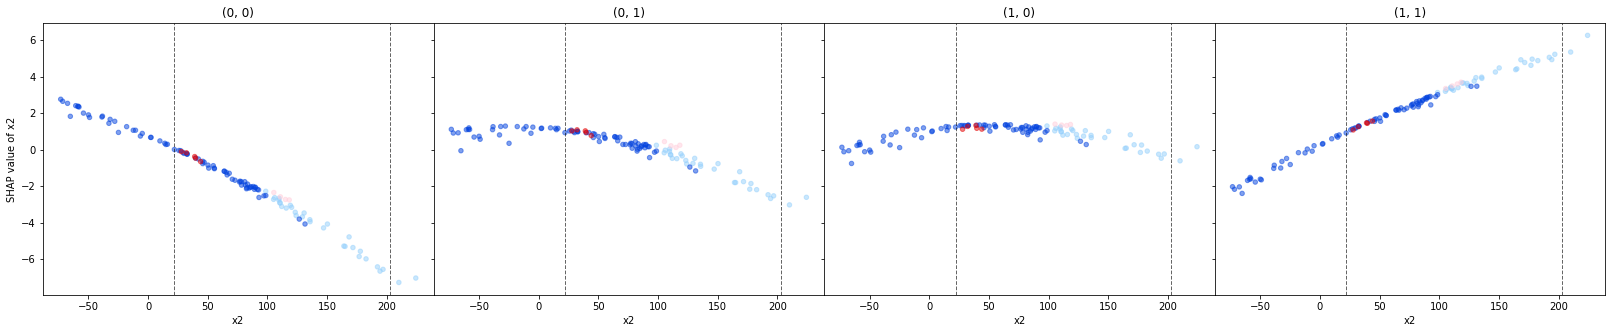

In [34]:
ref_node.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

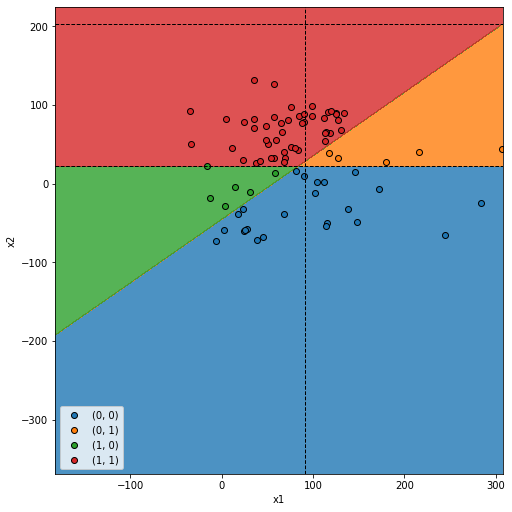

In [35]:
plot_2d_with_boundaries(node)

### Node 2.1 (LRLR)

In [36]:
ref_node = node
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRLR,
 (0, 1)    3
 (0, 0)    2
 dtype: int64,
 25.799822439185196)

117.36607682827199 <= x1
[Lower CF: x1 == 90.8 --> {'(1, 1)': 5}]


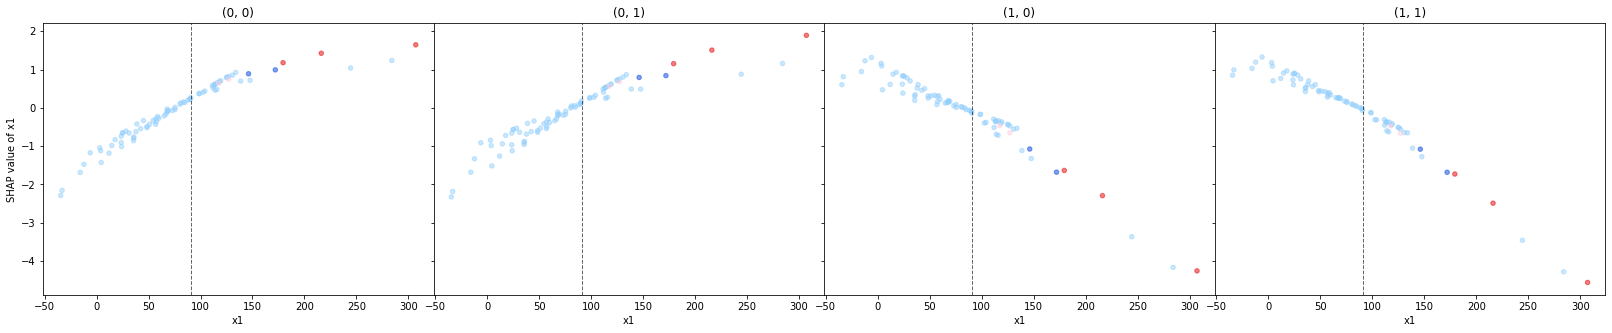

27.9033330838305 <= x2 <= 43.996255745135436
[Lower CF: x2 == 22.1 --> {'(0, 0)': 5},
 Upper CF: x2 == 202.8 --> {'(1, 1)': 5}]


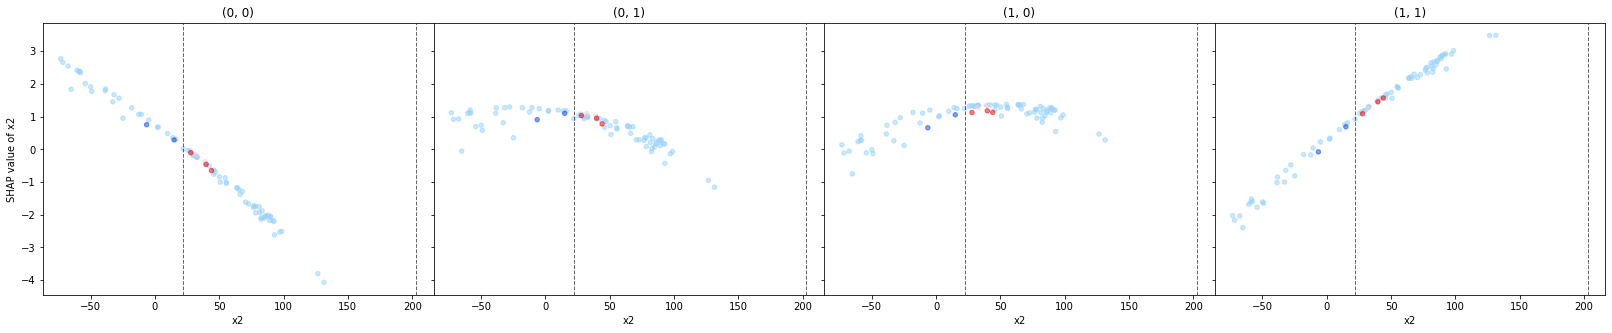

In [37]:
ref_node.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

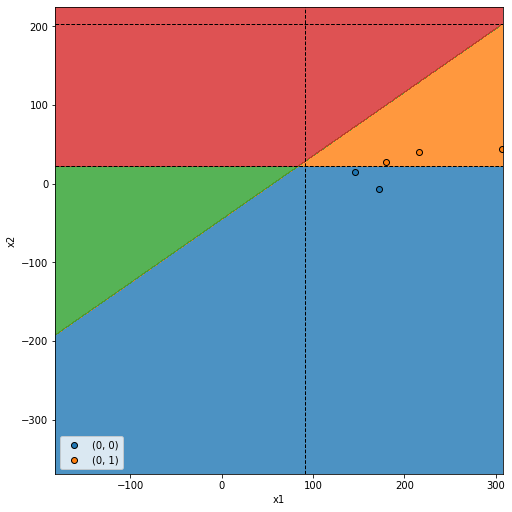

In [38]:
plot_2d_with_boundaries(node)

### Node 2.2 (LRRRRLLL)

In [39]:
node = ref_node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRRRLLL,
 (0, 1)    2
 dtype: int64,
 0.18825601334828174)

117.36607682827199 <= x1
[Lower CF: x1 == 90.8 --> {'(1, 1)': 5}]


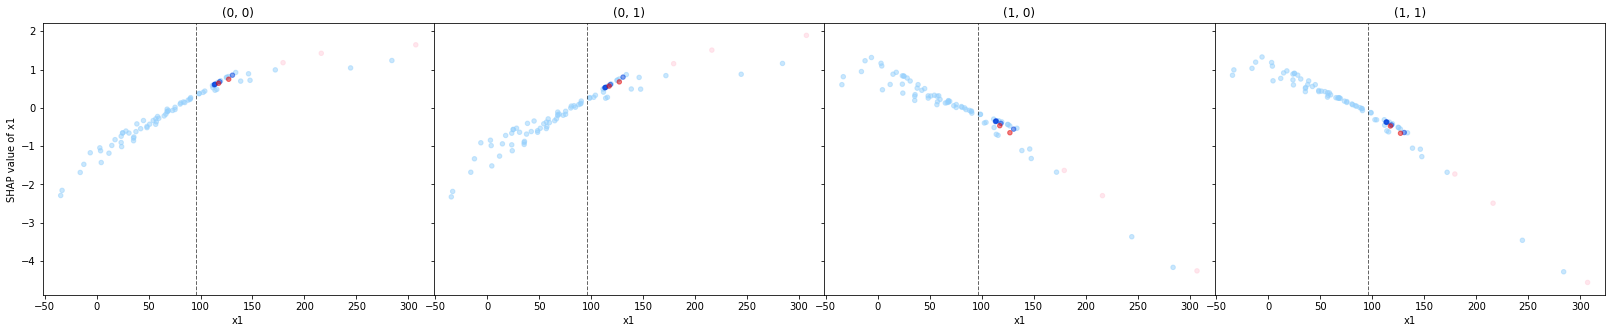

27.9033330838305 <= x2 <= 43.996255745135436
[Lower CF: x2 == 22.1 --> {'(0, 0)': 5},
 Upper CF: x2 == 202.8 --> {'(1, 1)': 5}]


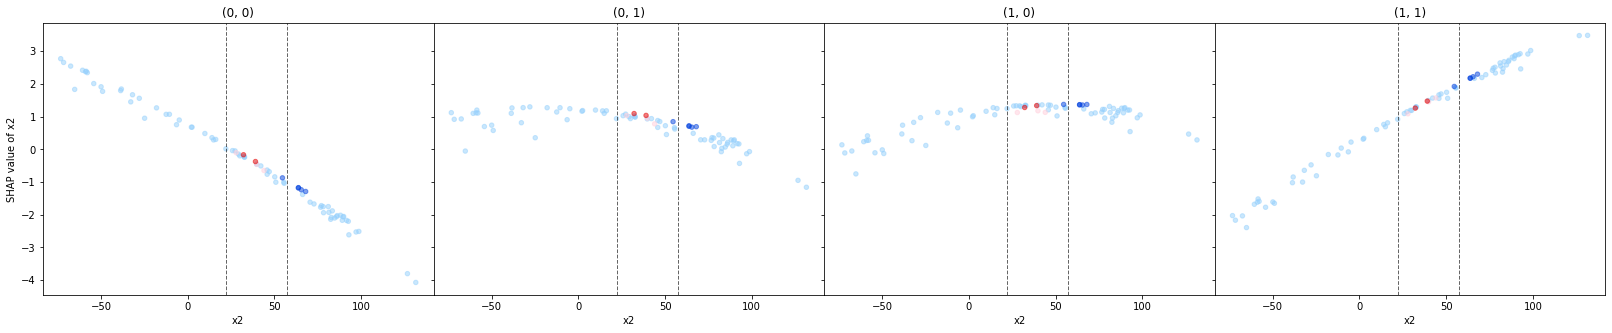

In [40]:
ref_node.plot_feature_dependence(*feature_names, focus=node.get_parent(), print_stats=True)

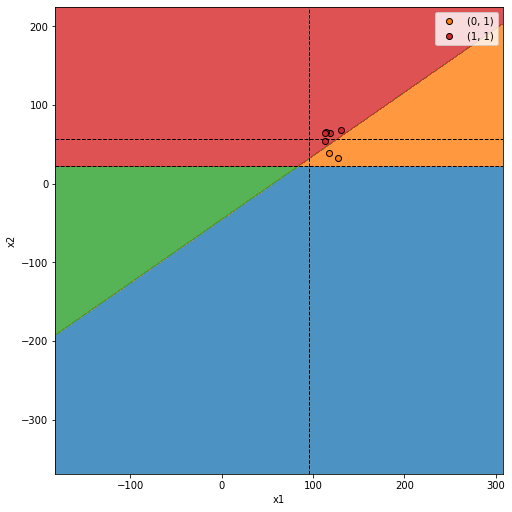

In [41]:
plot_2d_with_boundaries(node.get_parent())

## $(1, 0)$

In [42]:
node = load('(1, 0)')
node.distance, node.class_counts

(832.7059637114021,
 (1, 1)    78
 (0, 0)    57
 (0, 1)     9
 (1, 0)     6
 dtype: int64)

### Main Node (LRR)

In [43]:
node = node.root.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRR,
 (1, 1)    47
 (0, 0)    19
 (1, 0)     6
 (0, 1)     2
 dtype: int64,
 84.50792044740137)

-15.775584358870287 <= x1 <= 58.66508979458671
[Upper CF: x1 == 83.6 --> {'(0, 0)': 6}]


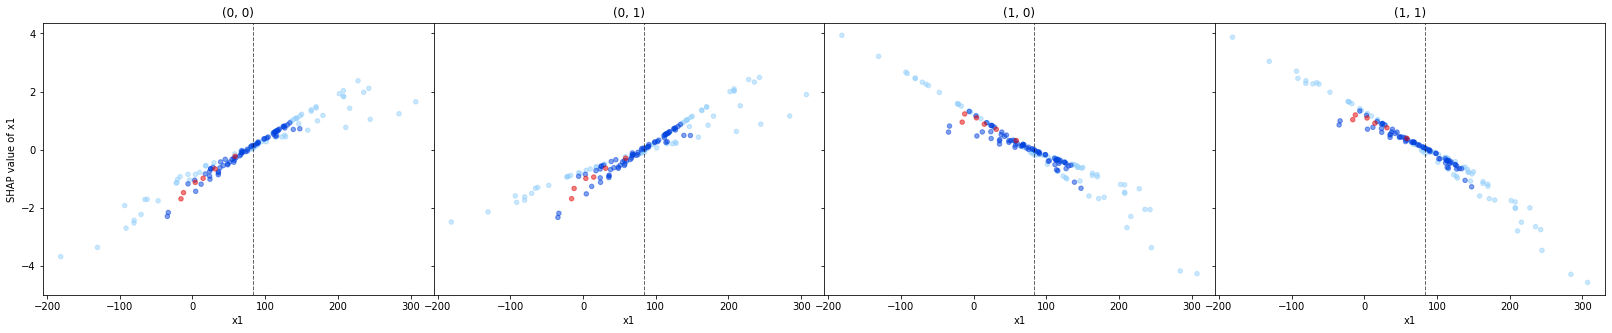

-27.904182410204744 <= x2 <= 22.006794155309727
[Lower CF: x2 == -58.3 --> {'(0, 0)': 6},
 Upper CF: x2 == 22.2 --> {'(1, 1)': 6}]


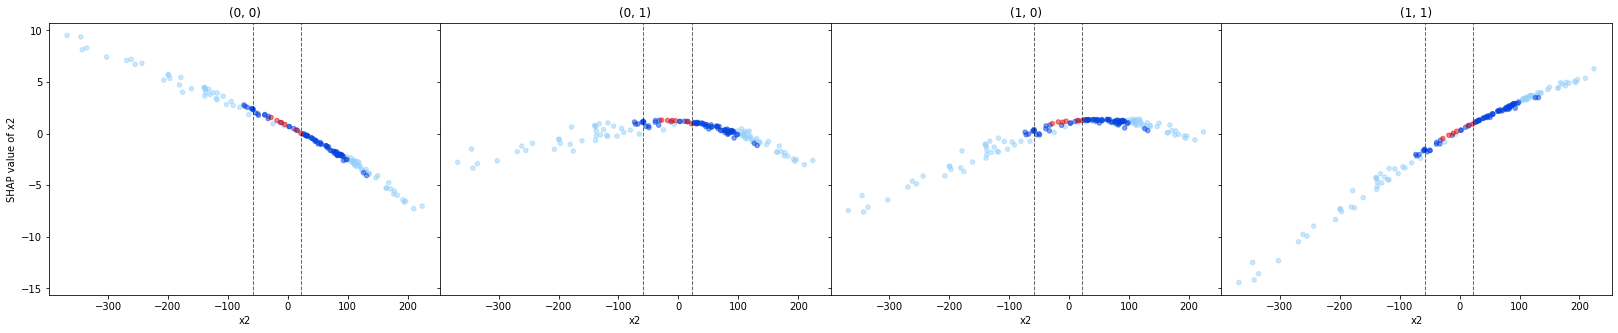

In [44]:
node.root.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

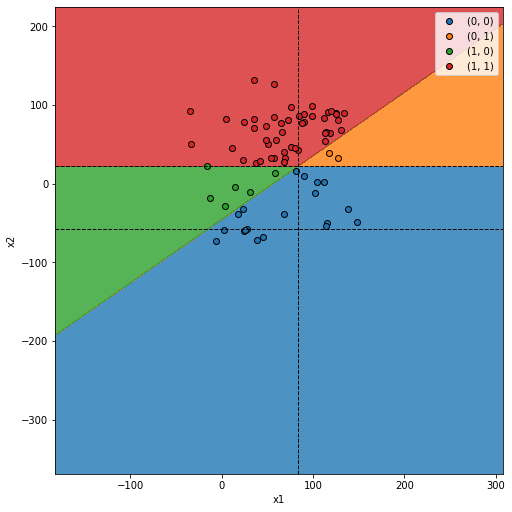

In [45]:
plot_2d_with_boundaries(node)

### Node 1 (LRRLLL)

In [46]:
ref_node = node
node = node.left.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRLLL,
 (1, 0)    4
 (0, 0)    2
 dtype: int64,
 2.329272198378159)

-15.775584358870287 <= x1 <= 58.66508979458671
[Upper CF: x1 == 83.6 --> {'(0, 0)': 6}]


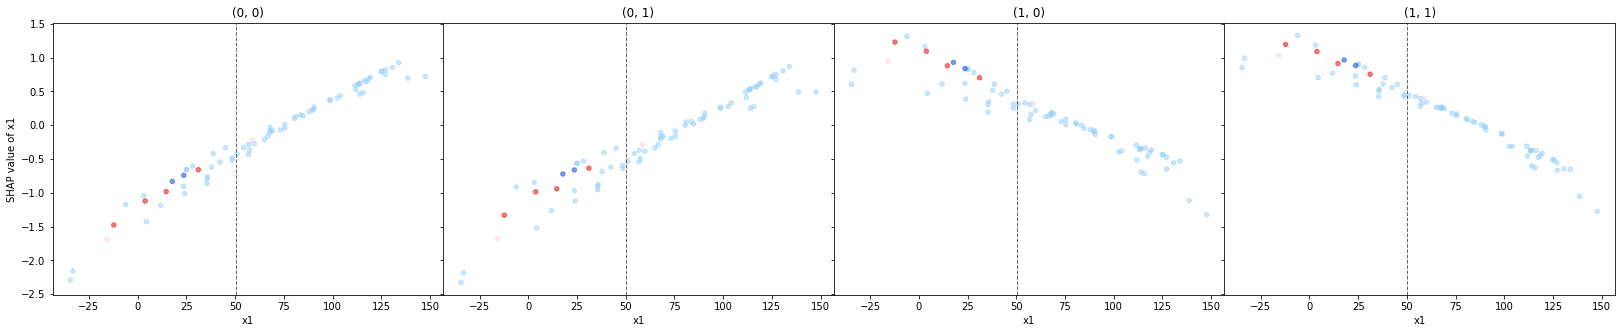

-27.904182410204744 <= x2 <= 22.006794155309727
[Lower CF: x2 == -58.3 --> {'(0, 0)': 6},
 Upper CF: x2 == 22.2 --> {'(1, 1)': 6}]


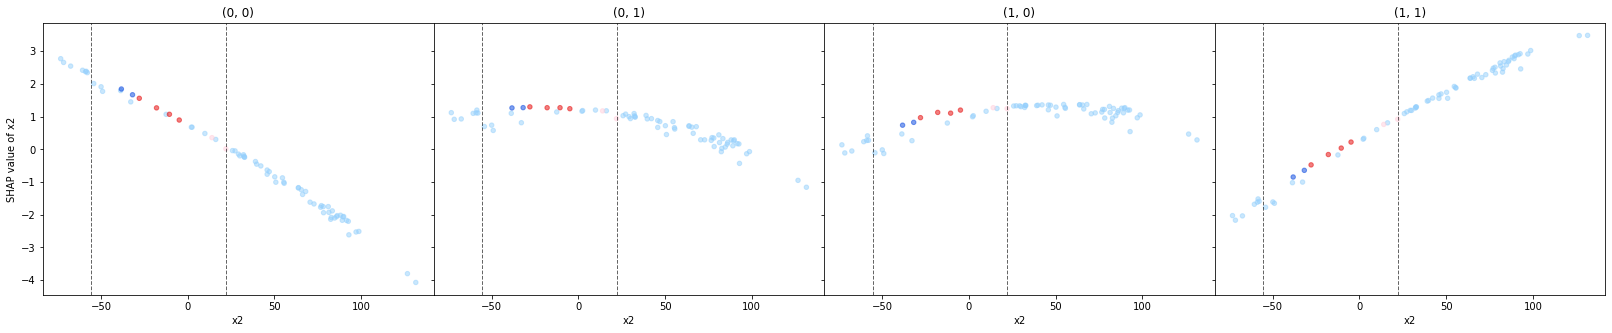

In [48]:
ref_node.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

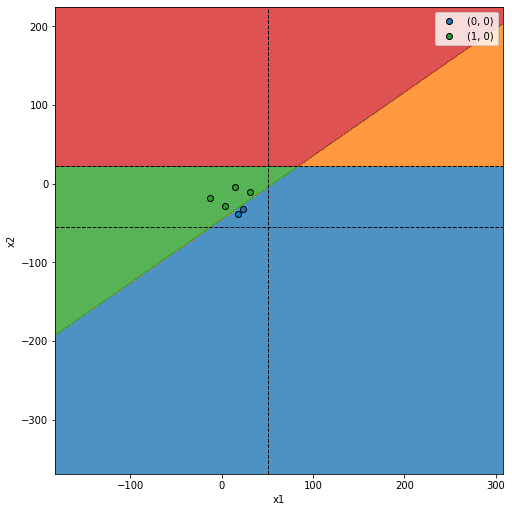

In [49]:
plot_2d_with_boundaries(node)

### Node 2 (LRRRRR)

In [50]:
node = ref_node.right.get_last_child_before_focus_class_split()
node, node.class_counts, node.distance

(LRRRRR,
 (1, 1)    17
 (1, 0)     2
 dtype: int64,
 12.484482435149843)

-15.775584358870287 <= x1 <= 58.66508979458671
[Upper CF: x1 == 83.6 --> {'(0, 0)': 6}]


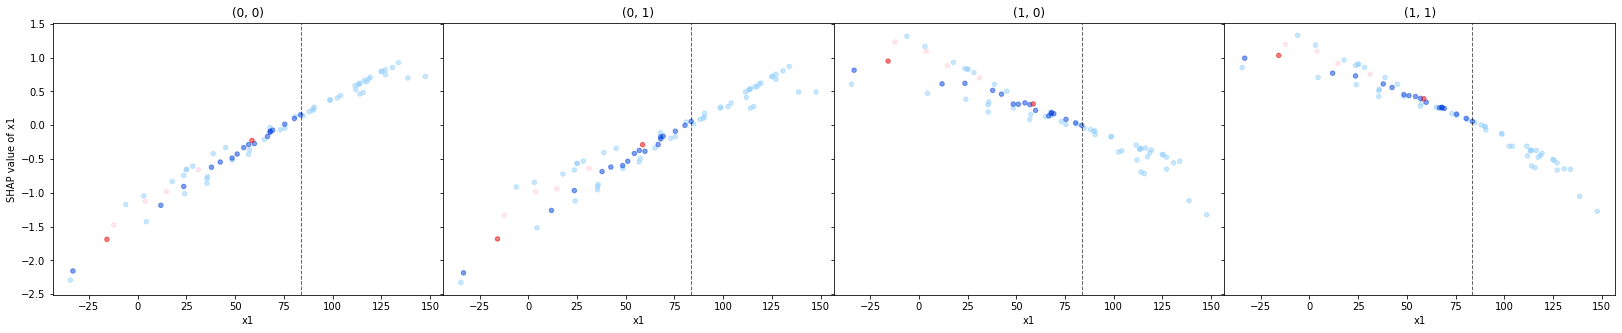

-27.904182410204744 <= x2 <= 22.006794155309727
[Lower CF: x2 == -58.3 --> {'(0, 0)': 6},
 Upper CF: x2 == 22.2 --> {'(1, 1)': 6}]


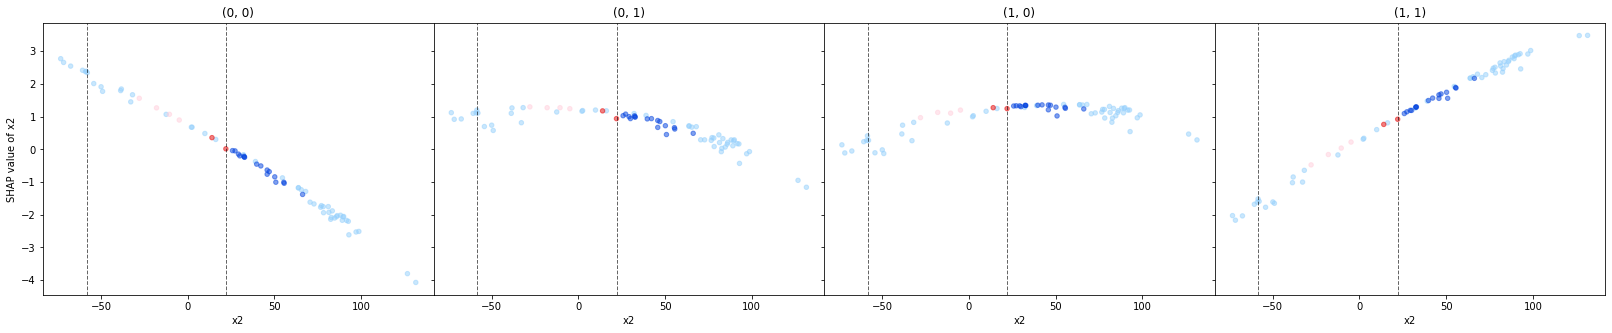

In [51]:
ref_node.plot_feature_dependence(*feature_names, focus=node, print_stats=True)

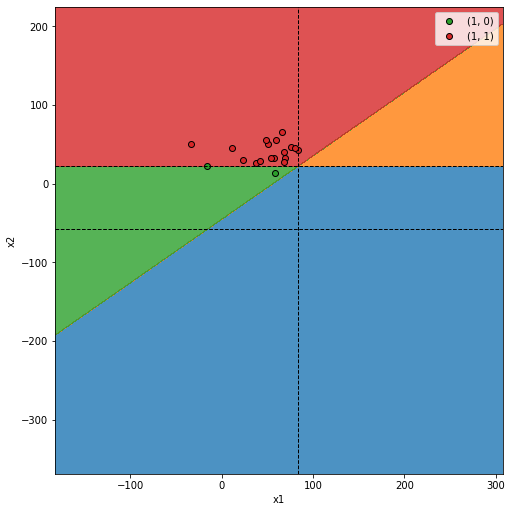

In [52]:
plot_2d_with_boundaries(node)

# Evaluation

In [31]:
with open('explanations/diffclf.log_odds.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

In [32]:
with open('data/test.pickle', 'rb') as f:
    X_test, y_test = pickle.load(f)

In [33]:
%%time
shap_values_test = generate_shap_explanations(comparer, X_test, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('explanations/test.log_odds.shap', 'wb') as f:
    pickle.dump(shap_values_test, f)

Exact explainer: 10001it [00:33, 236.07it/s]                          


CPU times: user 31.1 s, sys: 538 ms, total: 31.6 s
Wall time: 33.8 s


In [34]:
with open('explanations/test.log_odds.shap', 'rb') as f:
    shap_values_test = pickle.load(f)

In [35]:
explanations_per_class = {}
for class_name in comparer.class_names:
    explanations_per_class[class_name] = load(class_name)

In [36]:
metrics = eval_clusterings(explanations_per_class, X_test, y_test, shap_values_test, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Nodes,Constraints,Distance
0,0.780185,1.000000,0.876521,4213.0,"(0, 0)",1,1,832.705964
1,0.842980,0.999051,0.914404,4213.0,"(0, 0)",2,3,269.285518
2,0.842980,0.999051,0.914404,4213.0,"(0, 0)",3,4,117.062504
3,0.842980,0.999051,0.914404,4213.0,"(0, 0)",4,6,94.575025
4,0.842980,0.999051,0.914404,4213.0,"(0, 0)",5,8,84.507920
...,...,...,...,...,...,...,...,...
96,0.977711,0.993013,0.985302,3578.0,"(1, 1)",47,92,0.009115
97,0.977711,0.993013,0.985302,3578.0,"(1, 1)",48,94,0.006094
98,0.977711,0.993013,0.985302,3578.0,"(1, 1)",49,96,0.004968
99,0.977711,0.993013,0.985302,3578.0,"(1, 1)",50,98,0.000337


In [37]:
grouped_metrics, constraints = group_metrics(metrics, by='Distance', direction='down')

In [38]:
with open('data/fidelity-shap.pickle', 'wb') as f:
    pickle.dump((grouped_metrics, constraints), f)

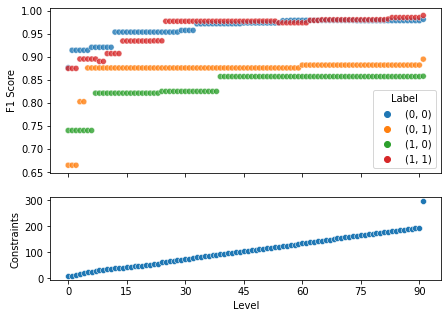

In [39]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [62]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Nodes    Distance  \
Level                                                                        
0     0  (0, 0)   0.780185  1.000000  0.876521   4213.0    1.0  832.705964   
      1  (0, 1)   0.498775  0.997062  0.664925   1021.0    1.0  832.705964   
      2  (1, 0)   0.663333  0.837542  0.740327   1188.0    1.0  832.705964   
      3  (1, 1)   0.777826  1.000000  0.875031   3578.0    1.0  832.705964   
1     0  (0, 0)   0.842980  0.999051  0.914404   4213.0    2.0  269.285518   
...         ...        ...       ...       ...      ...    ...         ...   
90    3  (1, 1)   0.977711  0.993013  0.985302   3578.0   50.0    0.000337   
91    0  (0, 0)   0.995604  0.967719  0.981464   4213.0   57.0    0.000000   
      1  (0, 1)   0.987013  0.818805  0.895075   1021.0    9.0    0.000000   
      2  (1, 0)   0.959417  0.776094  0.858074   1188.0    6.0    0.000000   
      3  (1, 1)   0.987212  0.992454  0.989826   3578.0   78.0    0.000000   

         Constraints  
Level                 
0     0          1.0  
      1          3.0  
      2          3.0  
      3          1.0  
1     0          3.0  
...              ...  
90    3         98.0  
91    0         98.0  
      1         27.0  
      2         18.0  
      3        154.0  

[368 rows x 8 columns]

In [63]:
constraints

Level
0       8.0
1      10.0
2      11.0
3      16.0
4      18.0
      ...  
87    189.0
88    190.0
89    192.0
90    194.0
91    297.0
Name: Constraints, Length: 92, dtype: float64

# Additional Material

In [19]:
feature_order = np.arange(len(feature_names))

In [20]:
root = load('(0, 1)')
nodes = dict([(name, root.get(node_name)) for name, node_name in
              [
                  ('Main Node', ''),
                  ('Node 1', 'LL'),
                  ('Node 2.1', 'LRL'),
                  ('Node 2.2', 'LRR')
              ]
             ])

In [21]:
for name, node in nodes.items():
    rule = node.rule_from_counterfactuals(order=feature_order, latex=True)[0]
    print(f'\item \emph{{{name}}}: ${rule}$')

\item \emph{Main Node}: $\mathit{x_1} > 90.8 \land 22.1 < \mathit{x_2} \leq 202.7$
\item \emph{Node 1}: $\mathit{x_1} > 186.6 \land 22.1 < \mathit{x_2} \leq 150.5$
\item \emph{Node 2.1}: $\mathit{x_1} > 90.8 \land 22.1 < \mathit{x_2} \leq 202.7$
\item \emph{Node 2.2}: $\mathit{x_1} > 96.1 \land 22.1 < \mathit{x_2} \leq 57.2$


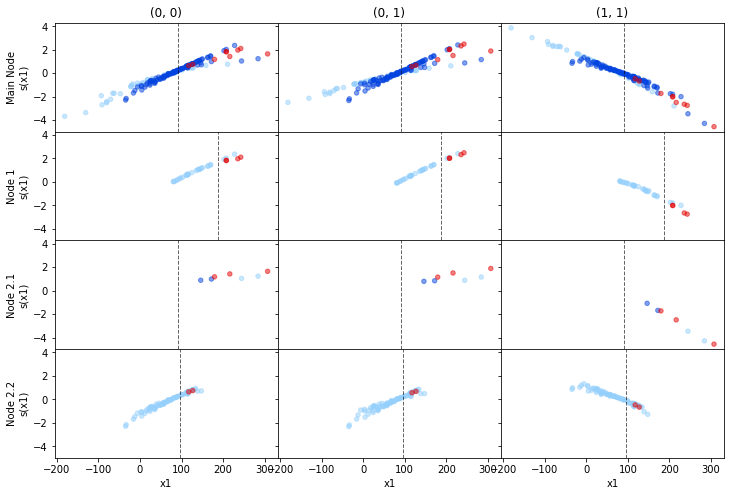

In [25]:
plot_joint_feature_dependence('x1', ['(0, 0)', '(0, 1)', '(1, 1)'], with_context=True, **nodes)
plt.savefig('figures/bign-depplots-01-x1.pdf', bbox_inches='tight')

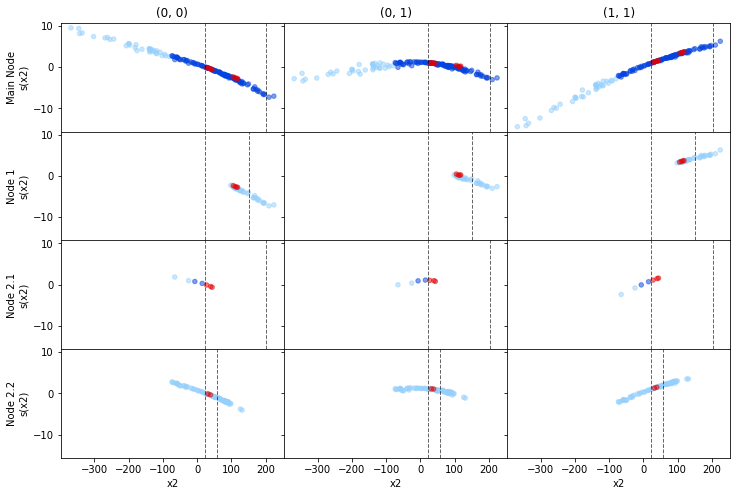

In [26]:
plot_joint_feature_dependence('x2', ['(0, 0)', '(0, 1)', '(1, 1)'], with_context=True, **nodes)
plt.savefig('figures/bign-depplots-01-x2.pdf', bbox_inches='tight')

In [27]:
root = load('(1, 0)')
nodes = dict([(name, root.get(cluster)) for name, cluster in
              [
                  ('Main Node', ''),
                  ('Node 1', 'LRRL'),
                  ('Node 2', 'LRRR')
              ]
             ])

In [28]:
for name, node in nodes.items():
    rule = node.rule_from_counterfactuals(order=feature_order, latex=True)[0]
    print(f'\item \emph{{{name}}}: ${rule}$')

\item \emph{Main Node}: $\mathit{x_1} \leq 83.5 \land -58.3 < \mathit{x_2} \leq 22.1$
\item \emph{Node 1}: $\mathit{x_1} \leq 50.2 \land -55.5 < \mathit{x_2} \leq 22.1$
\item \emph{Node 2}: $\mathit{x_1} \leq 83.5 \land -58.3 < \mathit{x_2} \leq 22.1$


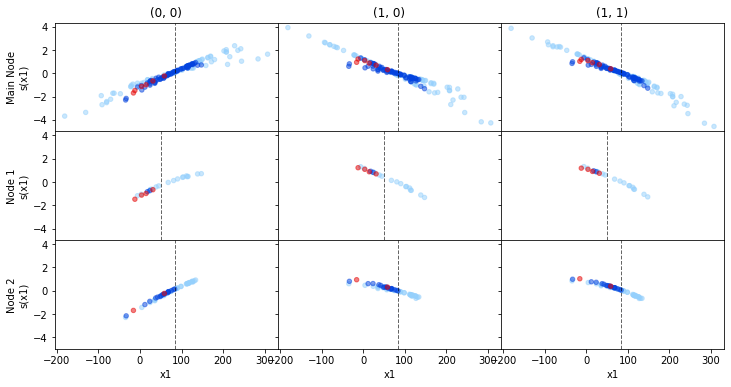

In [29]:
plot_joint_feature_dependence('x1', ['(0, 0)', '(1, 0)', '(1, 1)'], with_context=True, **nodes)
plt.savefig('figures/bign-depplots-10-x1.pdf', bbox_inches='tight')

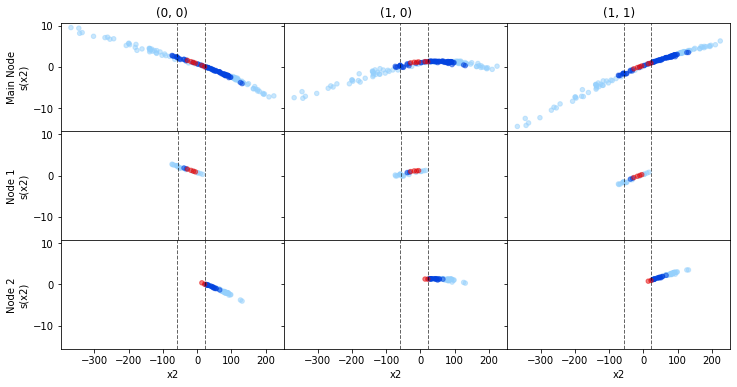

In [30]:
plot_joint_feature_dependence('x2', ['(0, 0)', '(1, 0)', '(1, 1)'], with_context=True, **nodes)
plt.savefig('figures/bign-depplots-10-x2.pdf', bbox_inches='tight')